In [1]:
%pip install transformers datasets scikit-learn torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json

EMOTIONS = [
    "sadness", "anger", "fear", "shame", "guilt", "loneliness", "confusion",
    "joy", "love", "hope", "pride", "relief"
]

with open("data/synthetic.json") as f:
    data = json.load(f)

texts = [item["text"] for item in data]
emotion_labels = [item["emotions"] for item in data]

In [4]:
from transformers import AutoTokenizer
from sklearn.preprocessing import MultiLabelBinarizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
mlb = MultiLabelBinarizer(classes=EMOTIONS)
binary_labels = mlb.fit_transform(emotion_labels)

encodings = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)


c:\Users\Eeeta\Projects\Bounce_Back\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['anxiety', 'gratitude', 'grief', 'nostalgia', 'regret', 'surprise'] will be ignored
  warnings.warn(


In [5]:
import torch
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.float)
        }

dataset = EmotionDataset(encodings, binary_labels)

In [6]:
from torch.utils.data import random_split, DataLoader

total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [7]:
from transformers import AutoModel
import torch.nn as nn

class EmotionBert(nn.Module):
    def __init__(self, num_labels=12):
        super().__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled)
        return torch.sigmoid(logits)

In [8]:
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionBert().to(device)

loss_fn = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

In [9]:
epochs = 10
train_losses, val_losses, test_losses = [], [], []
best_val_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train = total_loss / len(train_loader)
    train_losses.append(avg_train)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask)
            total_val_loss += loss_fn(outputs, labels).item()

    avg_val = total_val_loss / len(val_loader)
    val_losses.append(avg_val)

    # Save best model
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")

    # Test
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask)
            total_test_loss += loss_fn(outputs, labels).item()
    
    avg_test = total_test_loss / len(test_loader)
    test_losses.append(avg_test)
    print(f"Epoch {epoch+1} | Test Loss: {avg_test:.4f}")


Epoch 1 - Training: 100%|██████████| 213/213 [00:09<00:00, 21.98it/s]


Epoch 1 | Train Loss: 0.4328 | Val Loss: 0.3596
Epoch 1 | Test Loss: 0.3563


Epoch 2 - Training: 100%|██████████| 213/213 [00:09<00:00, 22.45it/s]


Epoch 2 | Train Loss: 0.3196 | Val Loss: 0.2776
Epoch 2 | Test Loss: 0.2640


Epoch 3 - Training: 100%|██████████| 213/213 [00:09<00:00, 22.38it/s]


Epoch 3 | Train Loss: 0.2416 | Val Loss: 0.2367
Epoch 3 | Test Loss: 0.2265


Epoch 4 - Training: 100%|██████████| 213/213 [00:09<00:00, 22.42it/s]


Epoch 4 | Train Loss: 0.1853 | Val Loss: 0.2167
Epoch 4 | Test Loss: 0.2096


Epoch 5 - Training: 100%|██████████| 213/213 [00:09<00:00, 22.45it/s]


Epoch 5 | Train Loss: 0.1423 | Val Loss: 0.2097
Epoch 5 | Test Loss: 0.2080


Epoch 6 - Training: 100%|██████████| 213/213 [00:09<00:00, 22.43it/s]


Epoch 6 | Train Loss: 0.1072 | Val Loss: 0.2031
Epoch 6 | Test Loss: 0.2028


Epoch 7 - Training: 100%|██████████| 213/213 [00:09<00:00, 22.48it/s]


Epoch 7 | Train Loss: 0.0828 | Val Loss: 0.2006
Epoch 7 | Test Loss: 0.2032


Epoch 8 - Training: 100%|██████████| 213/213 [00:09<00:00, 22.34it/s]


Epoch 8 | Train Loss: 0.0641 | Val Loss: 0.2095
Epoch 8 | Test Loss: 0.2018


Epoch 9 - Training: 100%|██████████| 213/213 [00:09<00:00, 22.31it/s]


Epoch 9 | Train Loss: 0.0503 | Val Loss: 0.2179
Epoch 9 | Test Loss: 0.2165


Epoch 10 - Training: 100%|██████████| 213/213 [00:09<00:00, 22.26it/s]


Epoch 10 | Train Loss: 0.0408 | Val Loss: 0.2183
Epoch 10 | Test Loss: 0.2144


C:\Users\Eeeta\AppData\Local\Temp\ipykernel_35188\4070061011.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Eeeta\Projects\Bounce_Back\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


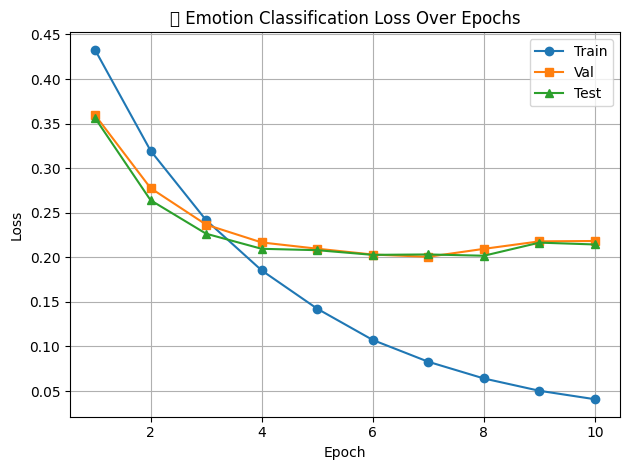

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, label='Train', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Val', marker='s')
plt.plot(range(1, epochs + 1), test_losses, label='Test', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('📉 Emotion Classification Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
torch.save(best_model_state, "model.pt")
print("✅ Saved model to model.pt")


In [11]:
# %%
import re
import numpy as np

def split_sentences(paragraph):
    return [s for s in re.split(r'(?<=[.!?])\s+', paragraph.strip()) if s]

def paragraph_to_emotion_stats(paragraph):
    sentences = split_sentences(paragraph)
    scores = []

    for s in sentences:
        inputs = tokenizer(s, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            output = model(inputs["input_ids"], inputs["attention_mask"])
        scores.append(output.squeeze().cpu().numpy())

    scores = np.array(scores)
    avg_scores = scores.mean(axis=0)
    emotion_dict = {EMOTIONS[i]: round(float(avg_scores[i]), 3) for i in range(len(EMOTIONS))}
    top_emotions = [emo for emo, score in emotion_dict.items() if score > 0.5]

    result = {
        "sentences": sentences,
        "average_scores": emotion_dict,
        "predicted_emotions": top_emotions
    }

    format_emotion_output(result)
    return result

def format_emotion_output(result):
    print("📄 Paragraph Summary\n")

    print("🧾 Sentences:")
    for i, sent in enumerate(result["sentences"], 1):
        print(f"  {i}. {sent}")

    print("\n📊 Average Emotion Scores:")
    sorted_scores = sorted(result["average_scores"].items(), key=lambda x: x[1], reverse=True)
    for emotion, score in sorted_scores:
        bar = "█" * int(score * 20)
        print(f"  {emotion.ljust(10)}: {score:.3f} {bar}")

    print("\n🎯 Predicted Emotions (score > 0.5):")
    print("  " + ", ".join(result["predicted_emotions"]) if result["predicted_emotions"] else "  (none)")


In [12]:
test_paragraphs = [
    "I got the promotion! Everyone clapped, and I felt like I finally proved myself.",
    "I haven’t talked to anyone in days. The silence is louder than ever.",
    "I wanted to be angry, but mostly I just felt numb.",
    "He texted me out of the blue, and suddenly I felt everything all over again.",
    "I stood in front of the crowd and delivered every word with confidence. I earned this.",
    "They forgave me. I didn’t think they would. I’m still shaking.",
    "I’m exhausted. I try to be okay, but I feel like I’m fading into the background.",
    "When she smiled at me, it felt like coming home.",
    "I hate that I let them down again. I swore I wouldn’t.",
    "I don’t know what I’m doing. I feel lost, like I’m making it up as I go.",
    "He held my hand in the waiting room. Just that made everything a little easier.",
    "I miss my childhood. Things felt simpler back then.",
    "I just needed one thing to go right today. Just one.",
    "We stayed up laughing until 2am. I forgot what sadness felt like for a while.",
    "I know I should be happy for her, but something inside me feels hollow.",
    "The doctor said I’m in the clear. I cried in the car for fifteen minutes.",
    "She said I made her proud. I didn’t know how much I needed to hear that.",
    "I watched the sunset alone. Beautiful, but bittersweet.",
    "No one noticed I was gone. Not even a message.",
    "I aced the exam after weeks of struggling. This win feels personal.",
    "I opened up and they mocked me. I’ll never make that mistake again.",
    "She cooked dinner just for me. I felt seen.",
    "Everything was fine, and then it wasn’t. I don’t know how we got here.",
    "I got through the day without crying. That’s enough.",
    "The house feels empty without her. Even the walls are quiet.",
    "They all moved on, and I’m still here pretending it doesn’t hurt.",
    "The little kid gave me a sticker for helping him. It weirdly meant a lot.",
    "He lied. Again. And I believed him. Again.",
    "Everyone keeps telling me I’m strong. I wish they were right.",
    "I took the long way home just to avoid the place we used to go.",
    "He remembered my birthday. I hadn’t expected anyone to.",
    "There’s something comforting about rain when you’re sad. Like it gets it.",
    "I laughed out loud and didn’t fake it. That felt new.",
    "My heart was pounding the whole time, but I got through it.",
    "She still talks about me like I’m the bad guy. Maybe I am.",
    "I lit a candle, turned off my phone, and just sat. No noise. No pressure.",
    "I thought I was over it, but the tears still came.",
    "He said he loved me, but he looked away when he said it.",
    "I cleaned my whole apartment today. It gave me a sense of control.",
    "I confessed what I did. It felt like letting go of a thousand-pound weight.",
    "Sometimes I feel invisible, even when I’m surrounded by people.",
    "I didn’t know I could feel this happy just from a hug.",
    "Everything in my chest loosened when I saw the email. I got in.",
    "We hugged goodbye and I realized I might never see him again.",
    "She believes in me even when I don’t. I don’t get it.",
    "It was my fault. All of it. And I can’t undo it.",
    "We danced in the kitchen with no music. Just us.",
    "I kept it together all day and broke down brushing my teeth.",
    "Sometimes I smile and it’s real. Not always, but sometimes.",
    "I forgot how much I missed my sister’s voice.",
    "I didn’t feel anything. Not sadness. Not joy. Just static."
]



In [13]:
for paragraph in test_paragraphs:
    paragraph_to_emotion_stats(paragraph)

📄 Paragraph Summary

🧾 Sentences:
  1. I got the promotion!
  2. Everyone clapped, and I felt like I finally proved myself.

📊 Average Emotion Scores:
  pride     : 0.995 ███████████████████
  joy       : 0.406 ████████
  relief    : 0.061 █
  shame     : 0.030 
  confusion : 0.026 
  hope      : 0.026 
  sadness   : 0.020 
  fear      : 0.020 
  anger     : 0.014 
  love      : 0.012 
  loneliness: 0.011 
  guilt     : 0.007 

🎯 Predicted Emotions (score > 0.5):
  pride
📄 Paragraph Summary

🧾 Sentences:
  1. I haven’t talked to anyone in days.
  2. The silence is louder than ever.

📊 Average Emotion Scores:
  sadness   : 0.847 ████████████████
  loneliness: 0.821 ████████████████
  confusion : 0.115 ██
  fear      : 0.047 
  guilt     : 0.016 
  love      : 0.016 
  pride     : 0.010 
  anger     : 0.009 
  joy       : 0.008 
  relief    : 0.008 
  hope      : 0.007 
  shame     : 0.003 

🎯 Predicted Emotions (score > 0.5):
  sadness, loneliness
📄 Paragraph Summary

🧾 Sentences:
  1. 